In [2]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import os
from itertools import combinations

import numpy as np
import pickle
import data

import importlib
importlib.reload(data)

from data import update_expl_data, update_target_data, food_categories, preprocess_expl
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
"""
Set sample rate. In this notebook, all data will be resampled at the chosen frequency.
'MS' : Monthly (Month Start)
'W' : Weekly
'D' : Daily
"""

year_period = {'MS': 12, 'W': 52, 'D': 365}
frequency = 'MS'
one_year = year_period[frequency]
output_path = "./output/ensemble_202110/"

In [4]:
"""
Load food CPI data from January 1986 to the most recently available data.
"""

foodprice_df = update_target_data(food_categories, './data_files/food_cpi.csv')
# foodprice_df = pd.read_csv("./data_files/food_cpi.csv")
# foodprice_df = foodprice_df.set_index("REF_DATE")
# foodprice_df.index = pd.DatetimeIndex(foodprice_df.index)
foodprice_df = foodprice_df.resample(frequency).mean().interpolate()
foodprice_df

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
1986-01-01,69.300,70.900,60.600,59.100,67.300,76.000,65.100,77.500,76.000
1986-02-01,70.300,70.800,61.300,59.100,66.900,77.600,64.200,78.100,68.400
1986-03-01,70.600,71.100,61.300,59.300,67.000,79.200,64.200,78.600,66.200
1986-04-01,71.300,71.000,61.400,59.700,67.700,82.200,63.600,79.500,71.100
1986-05-01,71.200,71.400,61.900,59.900,68.200,83.500,64.000,79.800,75.300
...,...,...,...,...,...,...,...,...,...
2021-05-01,157.800,146.600,147.600,163.500,156.600,143.900,175.400,141.600,153.800
2021-06-01,157.700,145.300,146.200,163.900,156.800,144.500,176.700,142.200,153.400
2021-07-01,157.900,146.400,146.600,165.200,157.600,141.700,180.900,141.900,154.800


In [330]:
all_experiment_names = pd.Series(list(os.walk("./output"))[0][1])
all_experiment_names = all_experiment_names[~all_experiment_names.str.contains('ensemble')]
all_experiment_names

0     neuralprophet_202110_CPGRLE01CAM657N_nlags_24
1            neuralprophet_202110_CPIFABSL_nlags_48
2     neuralprophet_202110_IRLTLT01CAM156N_nlags_36
3                             nbeatsfredvars_202110
4             neuralprophet_202110_DEXCAUS_nlags_36
5     neuralprophet_202110_CPGRLE01CAM657N_nlags_48
6            neuralprophet_202110_CPIFABSL_nlags_24
7              neuralprophet_202110_UNRATE_nlags_60
8              neuralprophet_202110_VXOCLS_nlags_36
9          neuralprophet_202110_DCOILWTICO_nlags_24
10         neuralprophet_202110_DCOILWTICO_nlags_48
11    neuralprophet_202110_LRUNTTTTCAM156S_nlags_60
12         neuralprophet_202110_QCAR368BIS_nlags_48
13         neuralprophet_202110_QCAR368BIS_nlags_24
14    neuralprophet_202110_CPALCY01CAM661N_nlags_60
15     neuralprophet_202110_CUSR0000SAF113_nlags_24
16     neuralprophet_202110_CUSR0000SAF112_nlags_24
17     neuralprophet_202110_CUSR0000SAF113_nlags_48
18     neuralprophet_202110_CUSR0000SAF112_nlags_48
19         n

In [338]:
# experiment_names = ["nbeatsfredvars_202110", "nbeats_202110", "prophet_202110", "neuralprophet_202110_DCOILWTICO_nlags_24"]
# experiment_names = ["nbeatsfredvars_202110"]
# experiment_names = ["nbeats_202110", "prophet_202110"]
experiment_names = all_experiment_names.copy()
report_sim_dates = ["2015-07-01", "2016-07-01", "2017-07-01", "2018-07-01", "2019-07-01", "2020-07-01"]
sim_train_dates = {}
sim_valid_dates = {}

for date in report_sim_dates:
    sim_train_dates[date] = foodprice_df.index[foodprice_df.index <= date]
    sim_valid_dates[date] = foodprice_df.index[(foodprice_df.index > date) & (foodprice_df.index <= (pd.to_datetime(date) + pd.DateOffset(months=18)))]

In [339]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

metrics = {
    'r2_score': r2_score,
    'mae': mean_absolute_error,
    'mape': mean_absolute_percentage_error,
    'mse': mean_squared_error,
    'rmse': rmse
}

In [340]:
ex_name = "nbeats_202110"
sim_date = "2017-07-01"
fc = pd.read_csv(f"./output/{ex_name}/forecasts_{sim_date}.csv", index_col="REF_DATE")
fc.index = pd.DatetimeIndex(fc.index)
fc

,Bakery and cereal products (excluding baby food),Dairy products and eggs,"Fish, seafood and other marine products",Food purchased from restaurants,Food,"Fruit, fruit preparations and nuts",Meat,Other food products and non-alcoholic beverages,Vegetables and vegetable preparations
REF_DATE,,,,,,,,,
2017-08-01,153.7,135.8,138.0,146.6,144.1,136.6,157.4,135.7,133.6
2017-09-01,153.2,135.9,137.3,146.7,143.9,134.9,159.2,135.1,126.8
2017-10-01,151.9,133.7,136.2,146.1,142.5,134.2,157.1,134.0,126.6
2017-11-01,152.8,135.2,136.9,147.3,143.8,136.2,158.3,134.9,130.6
2017-12-01,153.3,134.9,136.7,148.9,145.6,138.7,160.0,134.9,137.0
2018-01-01,155.0,136.3,137.3,148.9,146.6,139.8,160.6,135.8,139.7
2018-02-01,153.5,136.4,136.9,148.7,146.0,139.7,159.3,136.6,140.7
2018-03-01,154.7,136.8,137.6,148.8,145.4,139.1,160.5,136.8,140.3
2018-04-01,154.0,135.8,137.8,149.6,146.7,139.7,161.1,136.9,140.4


In [341]:
def get_forecast_df(food_category, experiment_names, experiment_date):

    forecasts = []

    for ex_name in experiment_names:
        fc_df = pd.read_csv(f"./output/{ex_name}/forecasts_{experiment_date}.csv")
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        else:
            fc_df = fc_df.set_index("Unnamed: 0")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(ex_name)
        forecasts.append(fc_series)

    return pd.concat(forecasts, axis=1)

In [342]:
get_forecast_df("Meat", experiment_names, "2017-07-01")

FileNotFoundError: [Errno 2] No such file or directory: './output/final_forecasts/forecasts_2017-07-01.csv'

In [336]:
def eval_mean_forecast(foodprice_df, food_category, experiment_date, valid_dates):
      
    valid_series = foodprice_df.loc[valid_dates][food_category]                                 # Select the validation data. 
    all_forecasts = get_forecast_df(food_category, experiment_names, experiment_date)       # Produce the validation period forecast.
    mean_forecast = all_forecasts.mean(axis=1)
    std_forecast =  all_forecasts.std(axis=1)

    valid_metrics = {metric_name: metric_fn(y_true=valid_series,                        # Compute validation metrics. 
                                      y_pred=mean_forecast) for metric_name, metric_fn in metrics.items()}

    return valid_series, mean_forecast, std_forecast, valid_metrics

## Ensemble and evaluate forecasts

In [337]:
all_valid_metrics = {}
all_forecasts = {}

for report_sim_date in report_sim_dates:

    food_forecasts = {}
    food_scores = {}

    for category in food_categories:
        actual, fc, fc_std, scores = eval_mean_forecast(foodprice_df, category, date, sim_valid_dates[date])
        food_scores[category] = scores
        food_forecasts[category] = fc
        
    all_valid_metrics[report_sim_date] = food_scores
    all_forecasts[report_sim_date] = food_forecasts

FileNotFoundError: [Errno 2] No such file or directory: './output/final_forecasts/forecasts_2020-07-01.csv'

In [314]:
valid_metrics_concat = {}

all_valid_metrics.keys()

for report_date, valid_scores in all_valid_metrics.items():
    valid_metrics_concat[report_date] = pd.DataFrame(valid_scores).T
index = valid_metrics_concat[report_date].index
columns = valid_metrics_concat[report_date].columns
scores = [df.values for date, df in valid_metrics_concat.items()]
mean_scores = pd.DataFrame(np.array(scores).mean(axis=0), index=index, columns=columns)
# mean_scores.to_csv(f"{output_path}/mean_fc_valid_metrics.csv")
mean_scores

,r2_score,mae,mape,mse,rmse
Bakery and cereal products (excluding baby food),-5.930,3.083,0.020,10.621,3.259
Dairy products and eggs,-1.546,3.500,0.024,17.791,4.218
"Fish, seafood and other marine products",-7.216,3.868,0.027,16.319,4.040
Food purchased from restaurants,-0.303,1.739,0.011,3.625,1.904
Food,0.668,0.941,0.006,1.070,1.034
"Fruit, fruit preparations and nuts",-1.701,2.281,0.016,7.705,2.776
Meat,0.333,3.394,0.019,17.084,4.133
Other food products and non-alcoholic beverages,0.187,1.878,0.013,4.829,2.197
Vegetables and vegetable preparations,-4.109,7.436,0.048,77.691,8.814


## Visualize All Forecasts

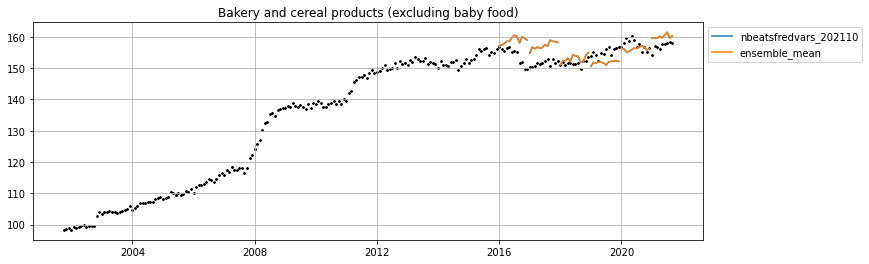

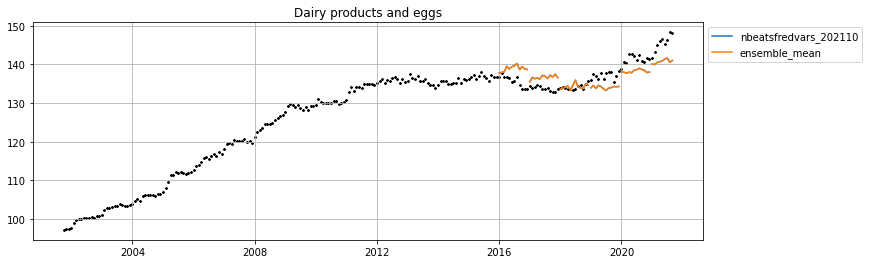

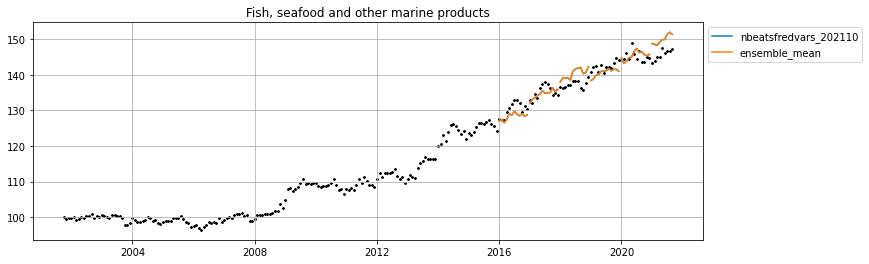

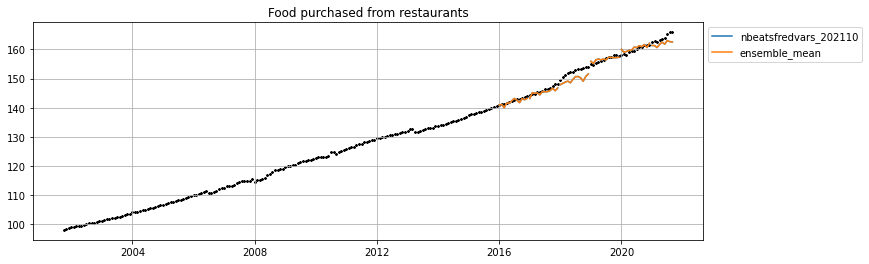

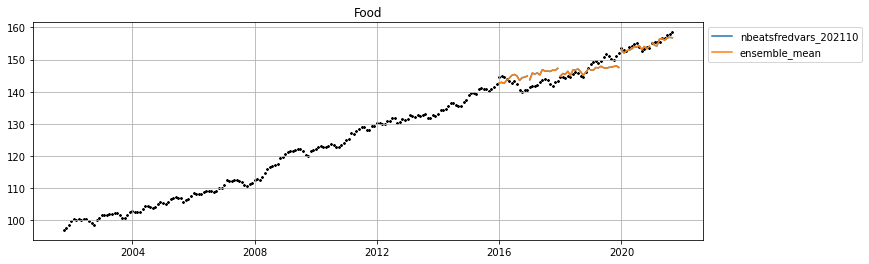

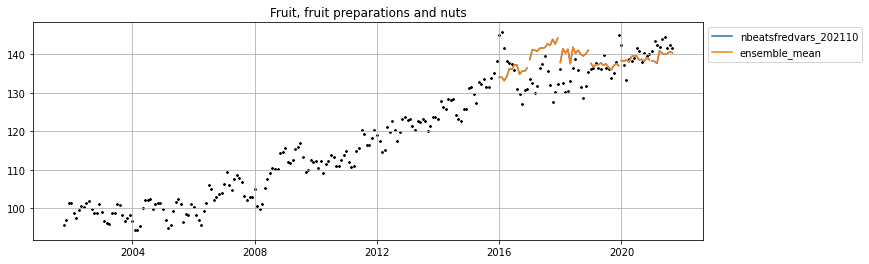

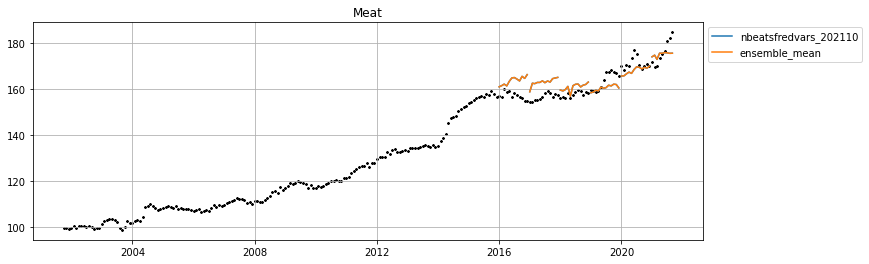

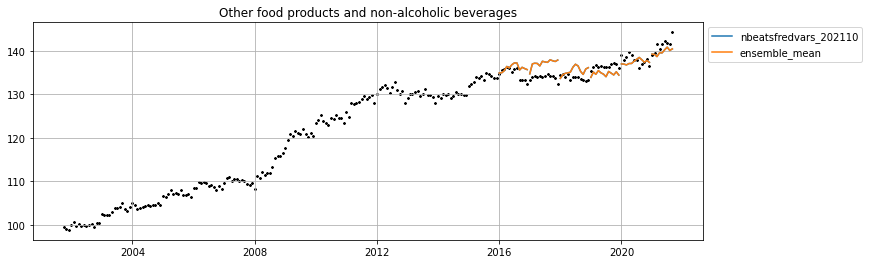

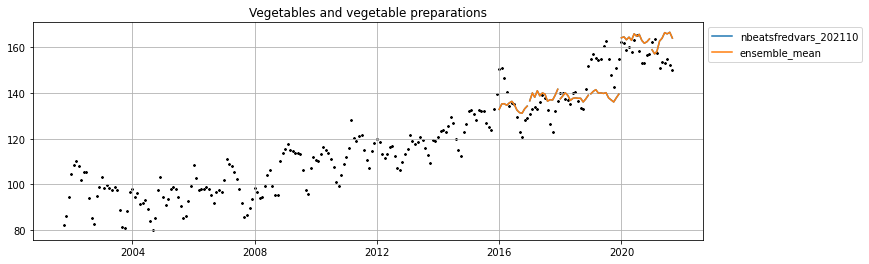

In [315]:
food_col_stats = {}

for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    date_stats = []

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, experiment_names, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]
        all_forecasts = all_forecasts.assign(ensemble_mean=all_forecasts.mean(axis=1))

        ax.scatter(foodprice_df[category].index[-240:], foodprice_df[category].iloc[-240:], color='black', s=1)

        col_stats = {}

        for index, col in enumerate(all_forecasts):

            # Collect some stats
            y_pred = all_forecasts[col]
            y_true = foodprice_df[category].loc[y_pred.index]
            col_stats[col] = y_pred - y_true

            if d_index < 1:
                ax.plot(all_forecasts[col], color=f"C{index}", label=col)
            else:
                ax.plot(all_forecasts[col], color=f"C{index}")

        date_stats.append(pd.DataFrame(col_stats))
    
    food_col_stats[category] = pd.concat(date_stats, axis=0)

    plt.title(category)
    plt.legend(bbox_to_anchor=(1,1))
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_raw_{category}.svg", bbox_inches='tight')
    plt.show()


In [316]:
from scipy.stats import ttest_1samp

all_t_stats = []

for col in food_col_stats:
    for exp_col in food_col_stats[col]:

        errors = food_col_stats[col][exp_col].dropna(axis=0).values
        t_stat, p_value = ttest_1samp(errors, popmean=0)
        # print(col, exp_col, t_stat, p_value)
        all_t_stats.append({"Category": col, "Experiment": exp_col, 't_statistic': t_stat, 'p_value': p_value})

In [317]:
pd.DataFrame(all_t_stats)

,Category,Experiment,t_statistic,p_value
0,Bakery and cereal products (excluding baby food),nbeatsfredvars_202110,3.609,0.001
1,Bakery and cereal products (excluding baby food),ensemble_mean,3.609,0.001
2,Dairy products and eggs,nbeatsfredvars_202110,-1.520,0.133
3,Dairy products and eggs,ensemble_mean,-1.520,0.133
4,"Fish, seafood and other marine products",nbeatsfredvars_202110,1.151,0.254
5,"Fish, seafood and other marine products",ensemble_mean,1.151,0.254
6,Food purchased from restaurants,nbeatsfredvars_202110,-5.114,0.000
7,Food purchased from restaurants,ensemble_mean,-5.114,0.000
8,Food,nbeatsfredvars_202110,1.302,0.197
9,Food,ensemble_mean,1.302,0.197


## Visualize Mean Forecasts

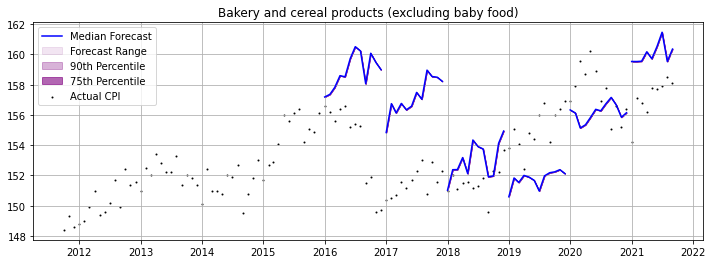

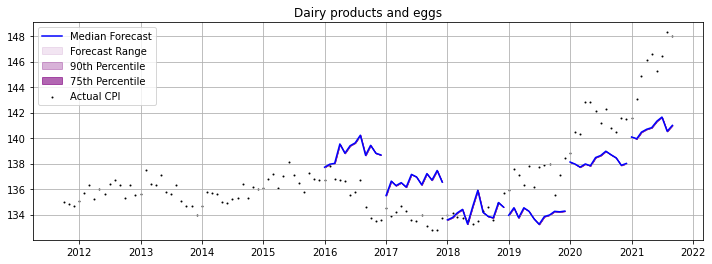

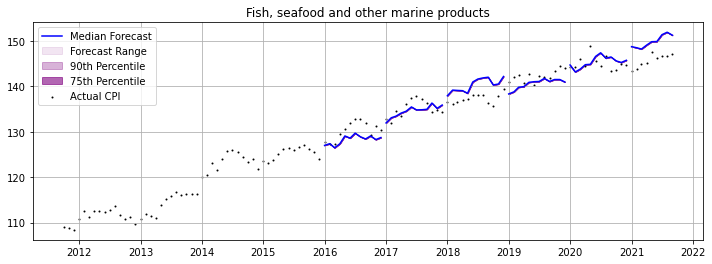

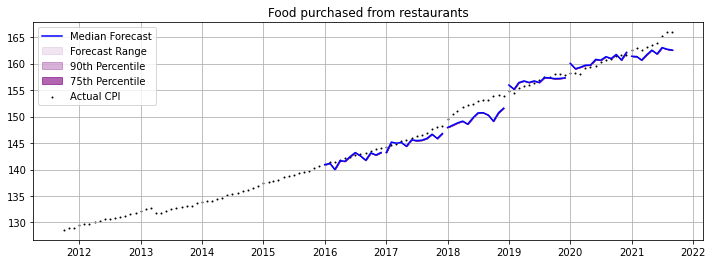

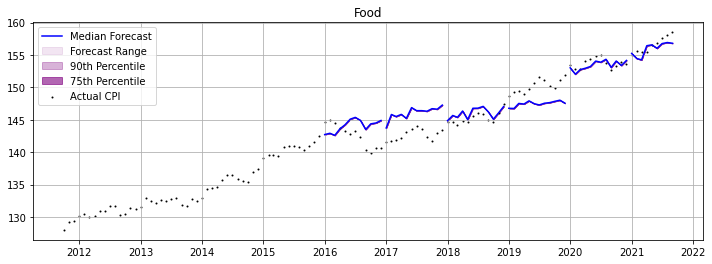

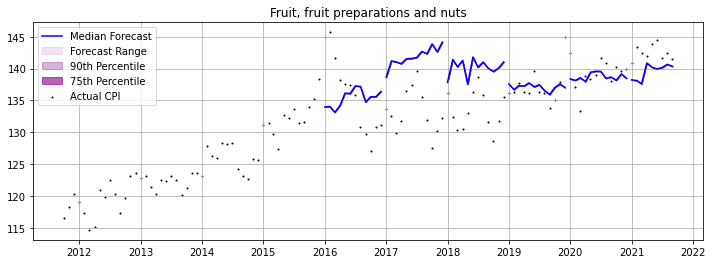

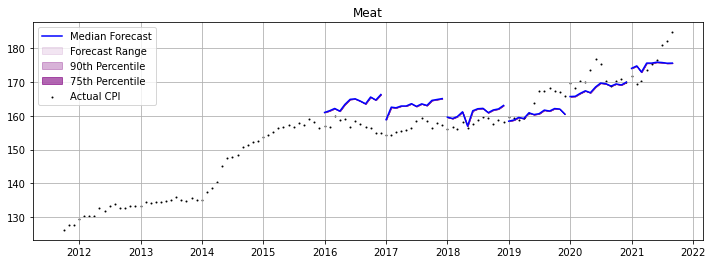

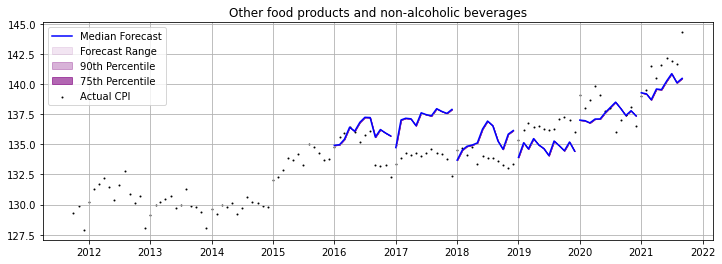

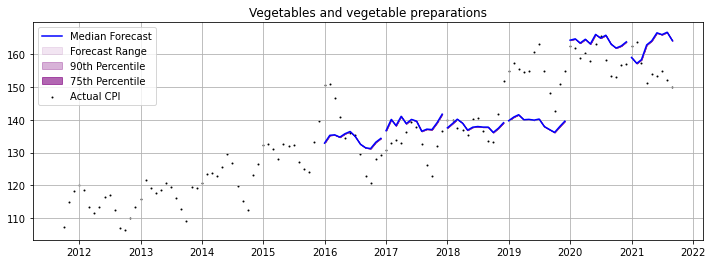

In [318]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, experiment_names, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]

        forecast_min = np.min(all_forecasts, axis=1) 
        forecast_10 = np.percentile(all_forecasts, 10, axis=1)
        forecast_25 = np.percentile(all_forecasts, 25, axis=1)
        forecast_75 = np.percentile(all_forecasts, 75, axis=1)
        forecast_90 = np.percentile(all_forecasts, 90, axis=1)
        forecast_max = np.max(all_forecasts, axis=1) 

        if d_index < 1:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red', label='Mean Forecast')
            ax.plot(all_forecasts.index, all_forecasts.median(axis=1), color='blue', label='Median Forecast')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple', label='Forecast Range')
            ax.fill_between(all_forecasts.index, forecast_10, forecast_90, alpha=0.3, color='purple', label='90th Percentile')
            ax.fill_between(all_forecasts.index, forecast_25, forecast_75, alpha=0.6, color='purple', label='75th Percentile')
        else:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red')
            ax.plot(all_forecasts.index, all_forecasts.median(axis=1), color='blue')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple')
            ax.fill_between(all_forecasts.index, forecast_10, forecast_90, alpha=0.3, color='purple')
            ax.fill_between(all_forecasts.index, forecast_25, forecast_75, alpha=0.6, color='purple')

    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=1, label="Actual CPI")
    plt.title(category)
    plt.legend(loc='upper left')
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_range_{category}.svg", bbox_inches='tight')
    plt.show()


## Search for the best-validating ensembles per-category over the whole validation period

With the multivariate NeuralProphet models, there are now many model configurations to choose from. Which ones should be combined and ensembled? Let's do this in a completely systematic way and find the configuration that validates best. We'll do this separately for each food price category.

In [177]:
all_combinations = []

for c_size in range(1, 4):
    for exp in combinations(experiment_names, c_size):
        all_combinations.append(exp)

print(len(all_combinations))

24857


In [178]:
category_config_scores = {}

for category in food_categories:

    print(f"Computing ensemble scores for {category}")

    config_scores = {}
    config_stddevs = {}

    for config_index, exp_config in enumerate(all_combinations):

        if config_index % 100 == 0:
            print(f"Processing config {config_index + 1} of {len(all_combinations)}...")

        valid_date_errors = []

        for d_index, date in enumerate(report_sim_dates):

            all_forecasts = get_forecast_df(category, exp_config, date)

            all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
            all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]

            mean_forecast = all_forecasts.mean(axis=1)
            actual_cpi = foodprice_df[category][mean_forecast.index]

            analysis_df = pd.DataFrame({'y': actual_cpi, 'yhat': mean_forecast})
            valid_date_errors.append(mean_absolute_percentage_error(y_true=analysis_df.y, y_pred=analysis_df.yhat))

        mean_mape = np.mean(valid_date_errors)
        std_mape = np.std(valid_date_errors)
        config_scores[str(exp_config)] = mean_mape
        config_stddevs[str(exp_config)] = std_mape
        
    category_config_scores[category] =  pd.DataFrame({'mape': config_scores, 'stddev': config_stddevs})  # pd.Series(config_scores, name='mape').to_frame()

Computing ensemble scores for Bakery and cereal products (excluding baby food)
Processing config 1 of 24857...
Processing config 101 of 24857...
Processing config 201 of 24857...
Processing config 301 of 24857...
Processing config 401 of 24857...
Processing config 501 of 24857...
Processing config 601 of 24857...
Processing config 701 of 24857...
Processing config 801 of 24857...
Processing config 901 of 24857...
Processing config 1001 of 24857...
Processing config 1101 of 24857...
Processing config 1201 of 24857...
Processing config 1301 of 24857...
Processing config 1401 of 24857...
Processing config 1501 of 24857...
Processing config 1601 of 24857...
Processing config 1701 of 24857...
Processing config 1801 of 24857...
Processing config 1901 of 24857...
Processing config 2001 of 24857...
Processing config 2101 of 24857...
Processing config 2201 of 24857...
Processing config 2301 of 24857...
Processing config 2401 of 24857...
Processing config 2501 of 24857...
Processing config 2601 

In [179]:
# pickle.dump(category_config_scores, open("./all_validation_mapes_large.pkl", 'wb'))

<AxesSubplot:ylabel='Frequency'>

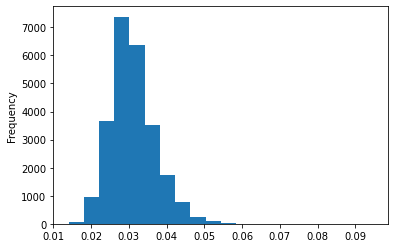

In [213]:
category_config_scores['Bakery and cereal products (excluding baby food)'].mape.plot(kind='hist', bins=20)

In [215]:
for category in food_categories:
    ensemble_results = category_config_scores[category].sort_values('mape')
    ensemble_results.to_csv(f"./report_output/ensemble_scores_{category}.csv")

In [220]:
category_config_scores["Meat"].head(60)

,mape,stddev
"('neuralprophet_202110_CPGRLE01CAM657N_nlags_24',)",0.059,0.035
"('neuralprophet_202110_CPIFABSL_nlags_48',)",0.049,0.027
"('neuralprophet_202110_IRLTLT01CAM156N_nlags_36',)",0.066,0.041
"('nbeatsfredvars_202110',)",0.027,0.010
"('neuralprophet_202110_DEXCAUS_nlags_36',)",0.060,0.047
"('neuralprophet_202110_CPIFABSL_nlags_24',)",0.057,0.028
"('neuralprophet_202110_UNRATE_nlags_60',)",0.056,0.035
"('neuralprophet_202110_VXOCLS_nlags_36',)",0.057,0.036
"('neuralprophet_202110_DCOILWTICO_nlags_24',)",0.055,0.027
"('neuralprophet_202110_DCOILWTICO_nlags_48',)",0.059,0.033


In [223]:
category_config_scores["Vegetables and vegetable preparations"].sort_values('mape')

,mape,stddev
"('neuralprophet_202110_DEXCAUS_nlags_24', 'neuralprophet_202110_WILL5000IND_nlags_60', 'neuralprophet_202110_CPGRLE01CAM657N_nlags_60')",0.029,0.012
"('nbeatsfredvars_202110', 'neuralprophet_202110_QCAR368BIS_nlags_60', 'neuralprophet_202110_CPGRLE01CAM657N_nlags_60')",0.029,0.015
"('neuralprophet_202110_WILL5000IND_nlags_60', 'neuralprophet_202110_DEXCAUS_nlags_60', 'neuralprophet_202110_CPGRLE01CAM657N_nlags_60')",0.029,0.008
"('nbeatsfredvars_202110', 'neuralprophet_202110_WILL5000IND_nlags_60', 'neuralprophet_202110_CPGRLE01CAM657N_nlags_60')",0.030,0.011
"('neuralprophet_202110_WILL5000IND_nlags_60', 'neuralprophet_202110_QCAR368BIS_nlags_60', 'neuralprophet_202110_CPGRLE01CAM657N_nlags_60')",0.030,0.010
...,...,...
"('neuralprophet_202110_DCOILWTICO_nlags_48',)",0.084,0.045
"('neuralprophet_202110_CUSR0000SAF112_nlags_24', 'neuralprophet_202110_CUSR0000SAF112_nlags_36')",0.085,0.035
"('neuralprophet_202110_DCOILWTICO_nlags_48', 'neuralprophet_202110_CUSR0000SAF112_nlags_36')",0.086,0.044
"('neuralprophet_202110_CUSR0000SAF112_nlags_36',)",0.092,0.049


In [280]:
results = {}
for category in food_categories:
    best_exp_config = category_config_scores[category].idxmin()['mape']
    best_exp_config = best_exp_config.replace("'",'').replace(' ', '').strip('()').split(',')
    results[category] = best_exp_config
    print(f"{category}\t{best_exp_config}\t{category_config_scores[category]['mape'].min()}\t{category_config_scores[category].sort_values('mape')['stddev'][0]}")

Bakery and cereal products (excluding baby food)	['neuralprophet_202110_IRLTLT01CAM156N_nlags_36', 'nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24']	0.014008609097695026	0.008770144190252646
Dairy products and eggs	['neuralprophet_202110_CUSR0000SAF112_nlags_48', 'nbeats_202110']	0.015452047564054801	0.005301280902776423
Fish, seafood and other marine products	['neuralprophet_202110_CUSR0000SAF113_nlags_48', 'nbeats_202110', 'neuralprophet_202110_QCAR368BIS_nlags_60']	0.010904770717824364	0.0020464826650983875
Food purchased from restaurants	['nbeatsfredvars_202110', 'nbeats_202110', 'neuralprophet_202110_WILL5000IND_nlags_36']	0.006103149198788679	0.003723796517897674
Food	['nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24', 'neuralprophet_202110_IRLTLT01CAM156N_nlags_60']	0.007596572815229053	0.002603308211955185
Fruit, fruit preparations and nuts	['neuralprophet_202110_CUSR0000SAF112_nlags_24', 'neuralprophet_202110_CUSR0000SAF112_nlags_36

In [281]:
results

{'Bakery and cereal products (excluding baby food)': ['neuralprophet_202110_IRLTLT01CAM156N_nlags_36',
  'nbeatsfredvars_202110',
  'neuralprophet_202110_CUSR0000SAF112_nlags_24'],
 'Dairy products and eggs': ['neuralprophet_202110_CUSR0000SAF112_nlags_48',
  'nbeats_202110'],
 'Fish, seafood and other marine products': ['neuralprophet_202110_CUSR0000SAF113_nlags_48',
  'nbeats_202110',
  'neuralprophet_202110_QCAR368BIS_nlags_60'],
 'Food purchased from restaurants': ['nbeatsfredvars_202110',
  'nbeats_202110',
  'neuralprophet_202110_WILL5000IND_nlags_36'],
 'Food': ['nbeatsfredvars_202110',
  'neuralprophet_202110_CUSR0000SAF112_nlags_24',
  'neuralprophet_202110_IRLTLT01CAM156N_nlags_60'],
 'Fruit, fruit preparations and nuts': ['neuralprophet_202110_CUSR0000SAF112_nlags_24',
  'neuralprophet_202110_CUSR0000SAF112_nlags_36',
  'neuralprophet_202110_CPALCY01CAM661N_nlags_24'],
 'Meat': ['nbeatsfredvars_202110',
  'neuralprophet_202110_CUSR0000SAF112_nlags_24',
  'nbeats_202110'],
 '

In [182]:
best_index = category_config_scores['Bakery and cereal products (excluding baby food)'].mape.idxmin()
category_config_scores['Bakery and cereal products (excluding baby food)'].loc[best_index]

mape     0.014
stddev   0.009
Name: ('neuralprophet_202110_IRLTLT01CAM156N_nlags_36', 'nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24'), dtype: float64

## Visualize the best ensemble forecasts per category and collect the best configuration MAPEs

Bakery and cereal products (excluding baby food)
['neuralprophet_202110_IRLTLT01CAM156N_nlags_36', 'nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24']



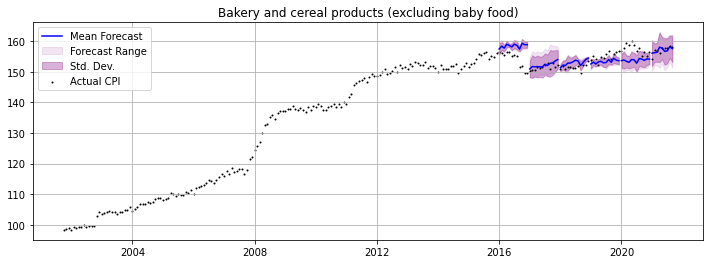

Dairy products and eggs
['neuralprophet_202110_CUSR0000SAF112_nlags_48', 'nbeats_202110']



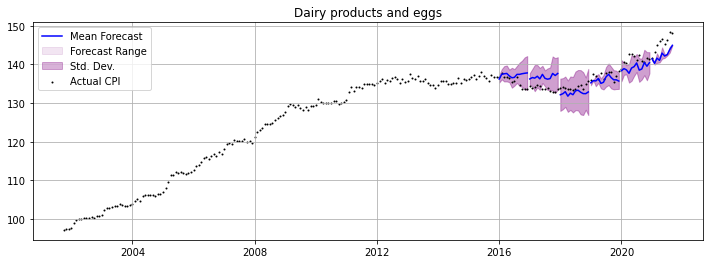

Fish, seafood and other marine products
['neuralprophet_202110_CUSR0000SAF113_nlags_48', 'nbeats_202110', 'neuralprophet_202110_QCAR368BIS_nlags_60']



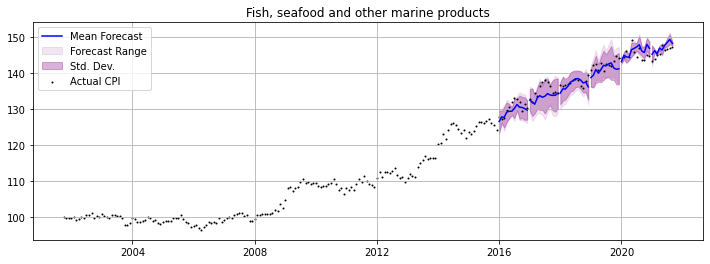

Food purchased from restaurants
['nbeatsfredvars_202110', 'nbeats_202110', 'neuralprophet_202110_WILL5000IND_nlags_36']



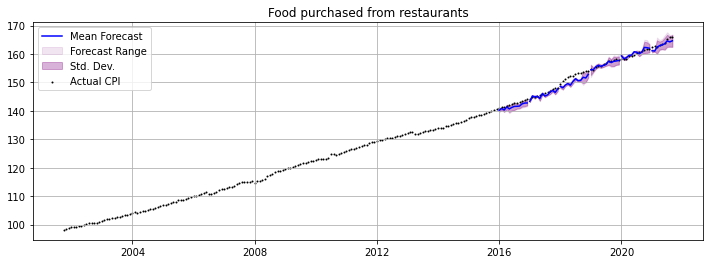

Food
['nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24', 'neuralprophet_202110_IRLTLT01CAM156N_nlags_60']



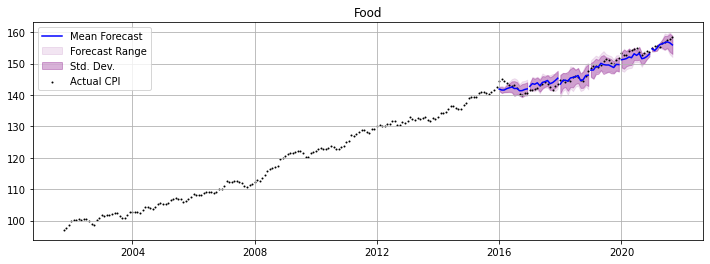

Fruit, fruit preparations and nuts
['neuralprophet_202110_CUSR0000SAF112_nlags_24', 'neuralprophet_202110_CUSR0000SAF112_nlags_36', 'neuralprophet_202110_CPALCY01CAM661N_nlags_24']



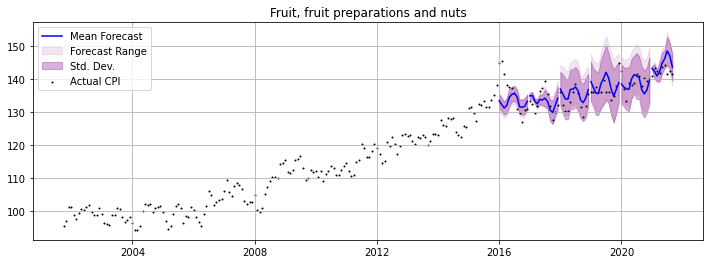

Meat
['nbeatsfredvars_202110', 'neuralprophet_202110_CUSR0000SAF112_nlags_24', 'nbeats_202110']



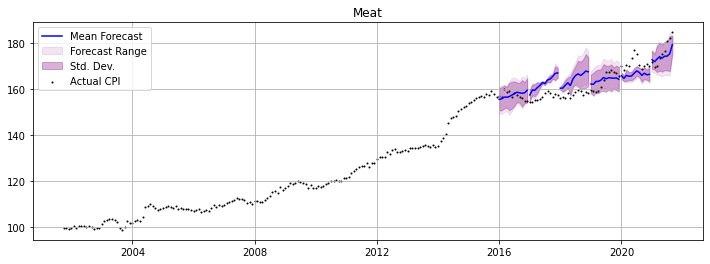

Other food products and non-alcoholic beverages
['neuralprophet_202110_VXOCLS_nlags_36', 'neuralprophet_202110_CUSR0000SAF112_nlags_24', 'prophet_202110']



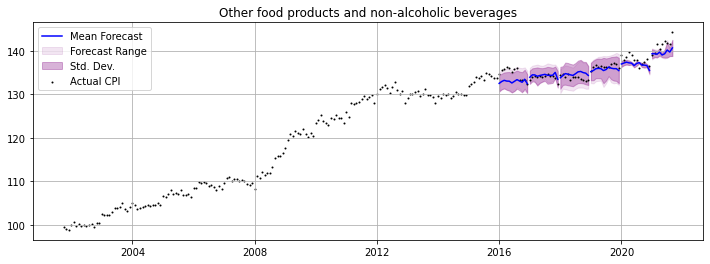

Vegetables and vegetable preparations
['neuralprophet_202110_DEXCAUS_nlags_24', 'neuralprophet_202110_WILL5000IND_nlags_60', 'neuralprophet_202110_CPGRLE01CAM657N_nlags_60']



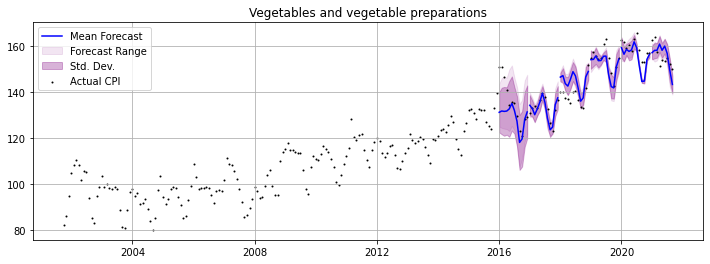

In [343]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    best_exp_config = category_config_scores[category].idxmin()['mape']
    best_exp_config = best_exp_config.replace("'",'').replace(' ', '').strip('()').split(',')
    best_exp_config = [config for config in best_exp_config if len(config) > 0]
    
    ## COMPARING
    # best_exp_config = ['nbeatsfredvars_202110']

    print(category)
    print(best_exp_config)
    print()

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, best_exp_config, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]

        forecast_min = np.min(all_forecasts, axis=1) 
        forecast_std = np.std(all_forecasts, axis=1)
        forecast_mean = np.mean(all_forecasts, axis=1)
        forecast_max = np.max(all_forecasts, axis=1) 

        if d_index < 1:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red', label='Mean Forecast')
            ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='blue', label='Mean Forecast')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple', label='Forecast Range')
            ax.fill_between(all_forecasts.index, forecast_mean - forecast_std, forecast_mean + forecast_std, alpha=0.3, color='purple', label='Std. Dev.')
        else:
            # ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='red')
            ax.plot(all_forecasts.index, all_forecasts.mean(axis=1), color='blue')
            ax.fill_between(all_forecasts.index, forecast_min, forecast_max, alpha=0.1, color='purple')
            ax.fill_between(all_forecasts.index,forecast_mean - forecast_std, forecast_mean + forecast_std, alpha=0.3, color='purple')

    ax.scatter(foodprice_df[category].index[-240:], foodprice_df[category].iloc[-240:], color='black', s=1, label="Actual CPI")
    plt.title(category)
    plt.legend(loc='upper left')
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_range_{category}.svg", bbox_inches='tight')
    plt.show()


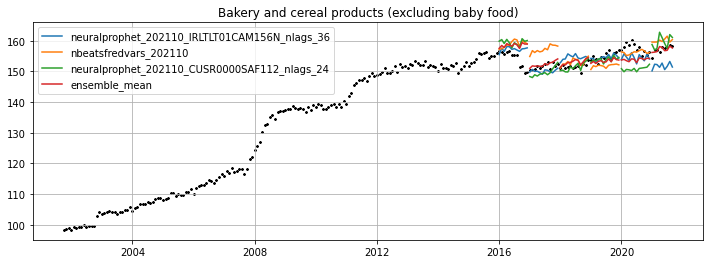

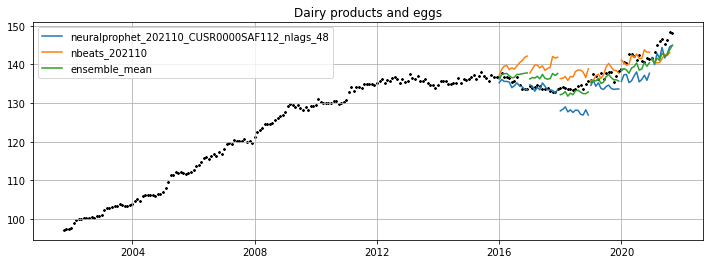

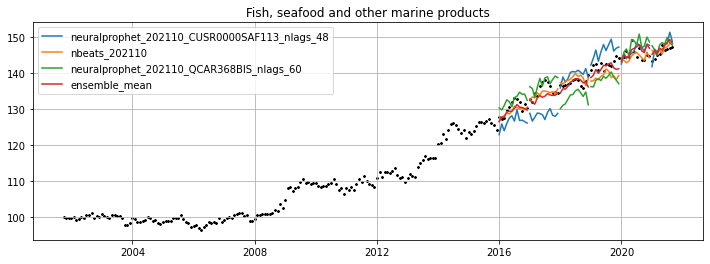

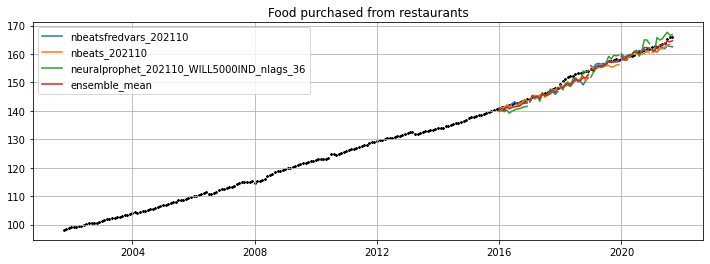

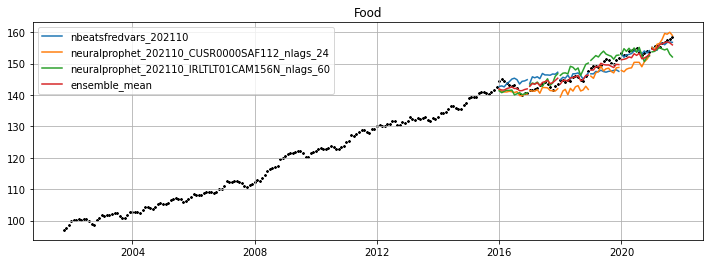

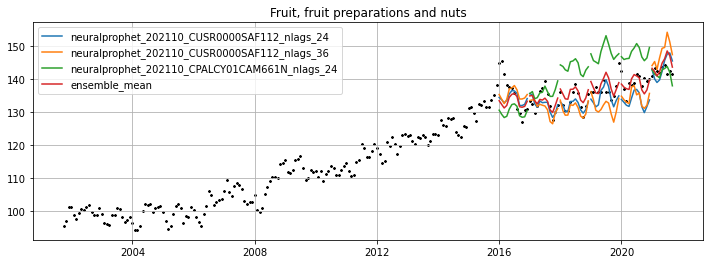

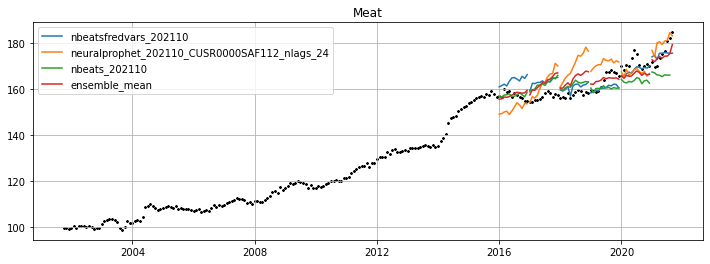

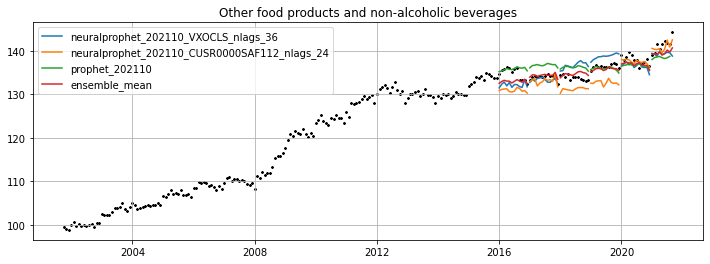

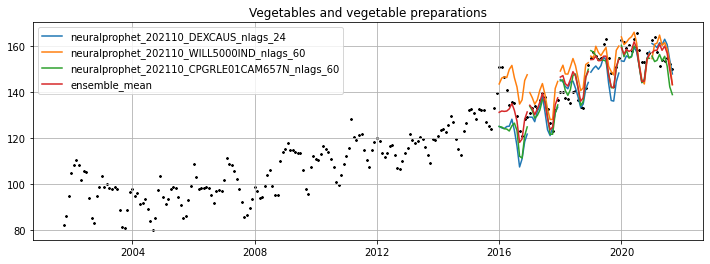

In [344]:
food_col_stats = {}

for category in food_categories:

    best_exp_config = category_config_scores[category].idxmin()['mape']
    best_exp_config = best_exp_config.replace("'",'').replace(' ', '').strip('()').split(',')
    best_exp_config = [config for config in best_exp_config if len(config) > 0]

    ## COMPARING
    # best_exp_config = ['nbeatsfredvars_202110']

    fig, ax = plt.subplots(figsize=(12,4))
    date_stats = []

    for d_index, date in enumerate(report_sim_dates):

        all_forecasts = get_forecast_df(category, best_exp_config, date)
        all_forecasts = all_forecasts.loc[all_forecasts.index >= pd.to_datetime(date) + pd.DateOffset(months=6)]
        all_forecasts = all_forecasts.loc[all_forecasts.index < pd.to_datetime(date) + pd.DateOffset(months=18)]
        all_forecasts = all_forecasts.assign(ensemble_mean=all_forecasts.mean(axis=1))

        ax.scatter(foodprice_df[category].index[-240:], foodprice_df[category].iloc[-240:], color='black', s=1)

        col_stats = {}

        for index, col in enumerate(all_forecasts):

            # Collect some stats
            y_pred = all_forecasts[col]
            y_true = foodprice_df[category].loc[y_pred.index]
            col_stats[col] = y_pred - y_true

            if d_index < 1:
                ax.plot(all_forecasts[col], color=f"C{index}", label=col)
            else:
                ax.plot(all_forecasts[col], color=f"C{index}")

        date_stats.append(pd.DataFrame(col_stats))
    
    food_col_stats[category] = pd.concat(date_stats, axis=0)

    plt.title(category)
    plt.legend(loc='best')
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_raw_{category}.svg", bbox_inches='tight')
    plt.show()


## Final forecast

In [349]:
def get_final_forecast_ensemble(food_category, results_dict):

    forecasts = []
    exp_results = results_dict[food_category]
    # exp_results = ['nbeatsfredvars_202110']

    # if 'nbeats_202110' not in exp_results:
    #     exp_results.append('nbeats_202110')
    # if 'prophet_202110' not in exp_results:
    #     exp_results.append('prophet_202110')
    # if 'nbeatsfredvars_202110' not in exp_results:
    #     exp_results.append('nbeatsfredvars_202110')
    for exp_name in exp_results:
        if exp_name.startswith('neuralprophet'):
            full_exp_name = f"{food_category}_{exp_name}".replace("_neuralprophet_202110_", '_')
            fc_df = pd.read_csv(f"./output/final_forecasts/{full_exp_name}/fc_final.csv")
        else:
            full_exp_name = exp_name
            fc_df = pd.read_csv(f"./output/{full_exp_name}/fc_final.csv")
        full_exp_name = full_exp_name.replace(f"{food_category}_", '')
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        elif "Unnamed: 0" in fc_df.columns:
            fc_df = fc_df.set_index("Unnamed: 0")
        elif "ds" in fc_df.columns:
            fc_df = fc_df.set_index("ds")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(full_exp_name)
        print(full_exp_name)
        forecasts.append(fc_series)
    
    return pd.concat(forecasts, axis=1)


In [350]:
final_forecasts_df = get_final_forecast_ensemble("Meat", results)
final_forecasts_df

nbeatsfredvars_202110
CUSR0000SAF112_nlags_24
nbeats_202110


,nbeatsfredvars_202110,CUSR0000SAF112_nlags_24,nbeats_202110
2021-10-01,183.2,180.0,181.8
2021-11-01,183.2,176.0,180.9
2021-12-01,182.9,179.1,179.7
2022-01-01,183.5,180.8,180.1
2022-02-01,184.8,181.2,181.5
2022-03-01,185.3,183.5,182.9
2022-04-01,186.4,186.3,183.2
2022-05-01,185.5,186.0,182.2
2022-06-01,187.0,182.7,185.0
2022-07-01,187.9,182.6,186.8


In [347]:
def get_final_forecast_df(food_category, experiment_names):

    forecasts = []

    for ex_name in experiment_names:
        fc_df = pd.read_csv(f"./output/{ex_name}/fc_final.csv")
        if "REF_DATE" in fc_df.columns:
            fc_df = fc_df.set_index("REF_DATE")
        elif "Unnamed: 0" in fc_df.columns:
            fc_df = fc_df.set_index("Unnamed: 0")
        elif "ds" in fc_df.columns:
            fc_df = fc_df.set_index("ds")
        fc_df.index = pd.DatetimeIndex(fc_df.index)
        fc_series = fc_df[food_category]
        fc_series = fc_series.rename(ex_name)
        forecasts.append(fc_series)

    return pd.concat(forecasts, axis=1)

In [348]:
final_forecasts_df = get_final_forecast_df("Meat", experiment_names)
final_forecasts_df

FileNotFoundError: [Errno 2] No such file or directory: './output/neuralprophet_202110_CPGRLE01CAM657N_nlags_24/fc_final.csv'

IRLTLT01CAM156N_nlags_36
nbeatsfredvars_202110
CUSR0000SAF112_nlags_24


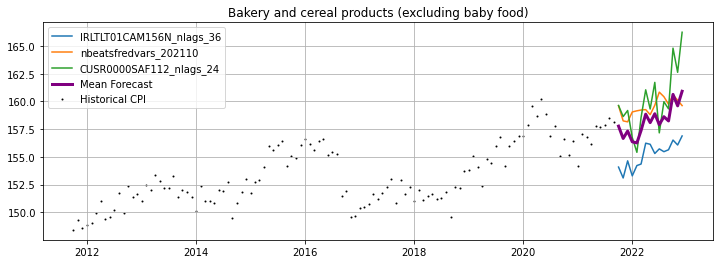

CUSR0000SAF112_nlags_48
nbeats_202110


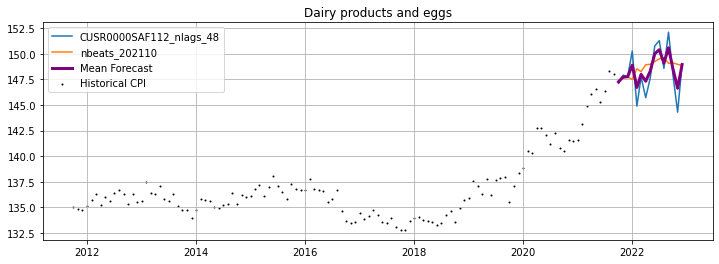

CUSR0000SAF113_nlags_48
nbeats_202110
QCAR368BIS_nlags_60


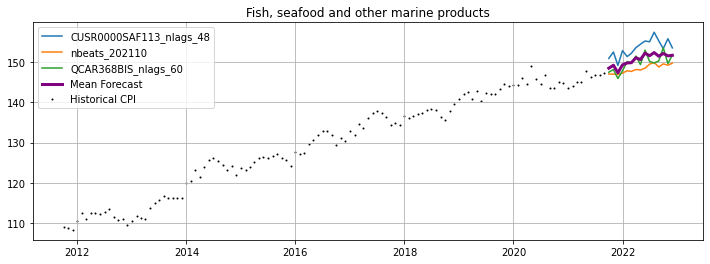

nbeatsfredvars_202110
nbeats_202110
WILL5000IND_nlags_36


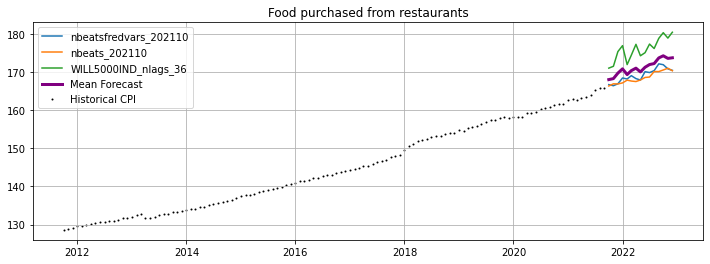

nbeatsfredvars_202110
CUSR0000SAF112_nlags_24
IRLTLT01CAM156N_nlags_60


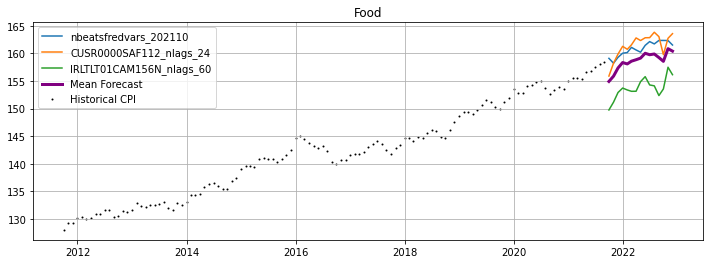

CUSR0000SAF112_nlags_24
CUSR0000SAF112_nlags_36
CPALCY01CAM661N_nlags_24


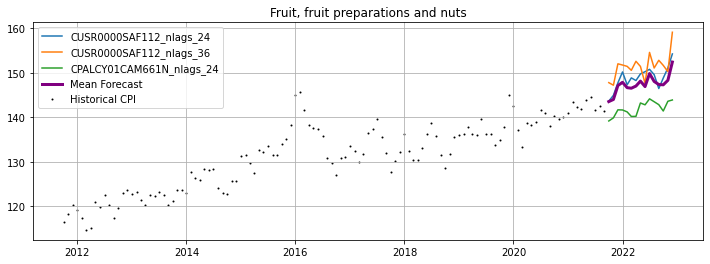

nbeatsfredvars_202110
CUSR0000SAF112_nlags_24
nbeats_202110


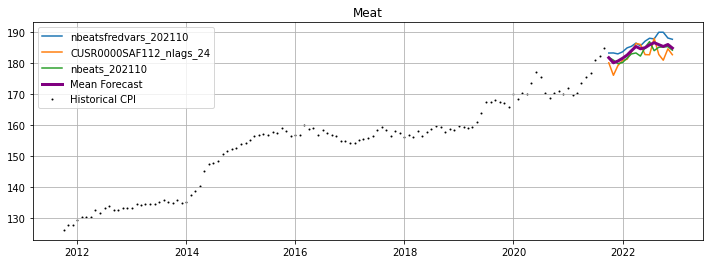

VXOCLS_nlags_36
CUSR0000SAF112_nlags_24
prophet_202110


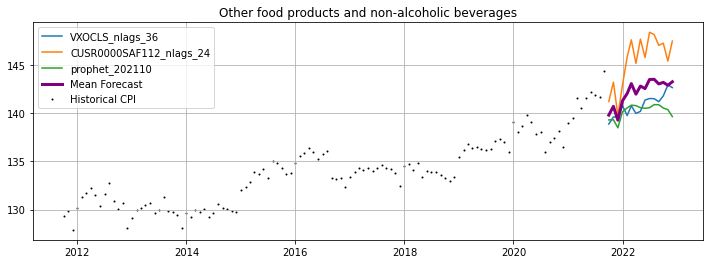

DEXCAUS_nlags_24
WILL5000IND_nlags_60
CPGRLE01CAM657N_nlags_60


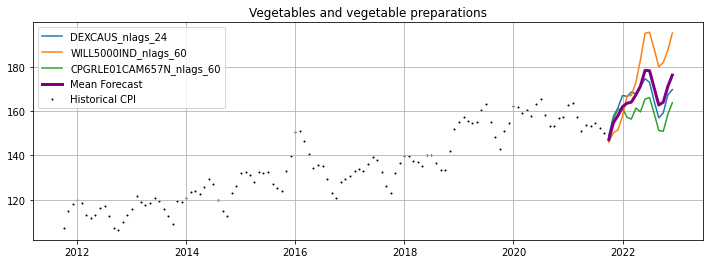

In [358]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    final_forecasts_df = get_final_forecast_ensemble(category, results)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]

    for index, col in enumerate(final_forecasts_df):
        ax.plot(final_forecasts_df[col], color=f"C{index}", label=col)

    ax.plot(final_forecasts_df.mean(axis=1), color="purple", label="Mean Forecast", lw=3)
    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=1, label='Historical CPI')

    plt.title(category)
    plt.legend()
    plt.grid()
    plt.savefig(f"./report_output/ensemble_forecast_raw_{category}.svg", bbox_inches='tight')
    plt.show()
    


IRLTLT01CAM156N_nlags_36
nbeatsfredvars_202110
CUSR0000SAF112_nlags_24


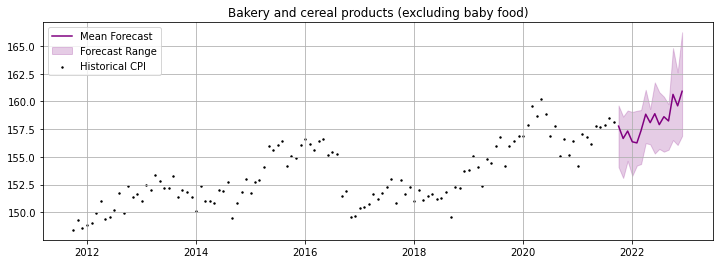

CUSR0000SAF112_nlags_48
nbeats_202110


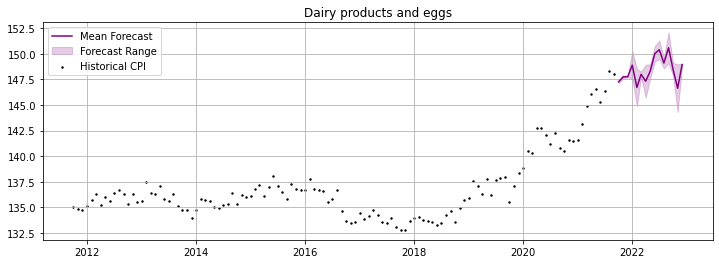

CUSR0000SAF113_nlags_48
nbeats_202110
QCAR368BIS_nlags_60


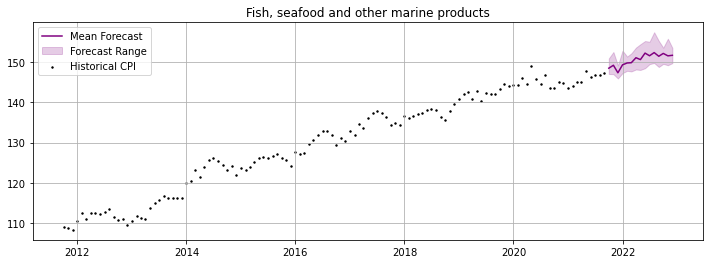

nbeatsfredvars_202110
nbeats_202110
WILL5000IND_nlags_36


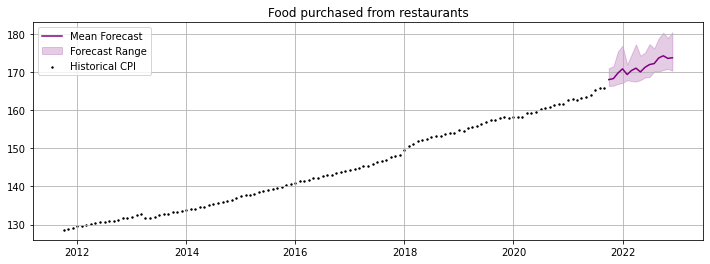

nbeatsfredvars_202110
CUSR0000SAF112_nlags_24
IRLTLT01CAM156N_nlags_60


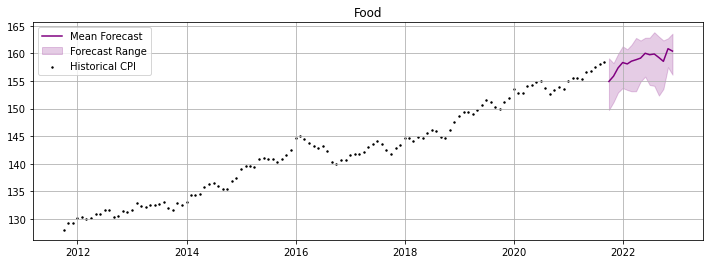

CUSR0000SAF112_nlags_24
CUSR0000SAF112_nlags_36
CPALCY01CAM661N_nlags_24


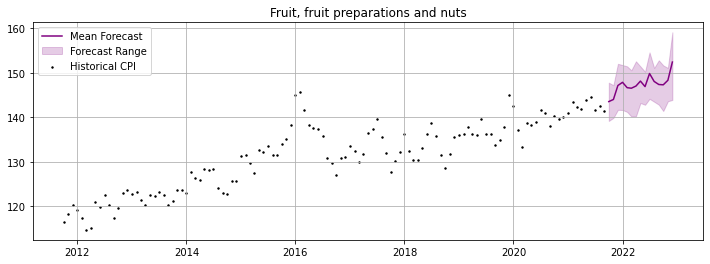

nbeatsfredvars_202110
CUSR0000SAF112_nlags_24
nbeats_202110


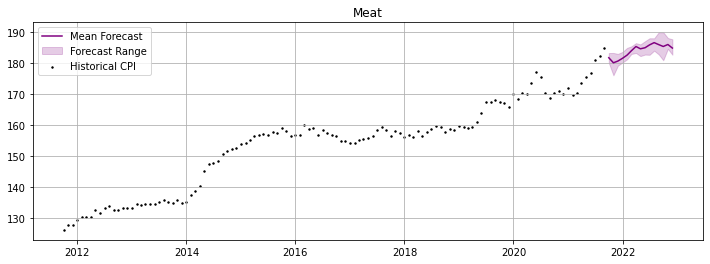

VXOCLS_nlags_36
CUSR0000SAF112_nlags_24
prophet_202110


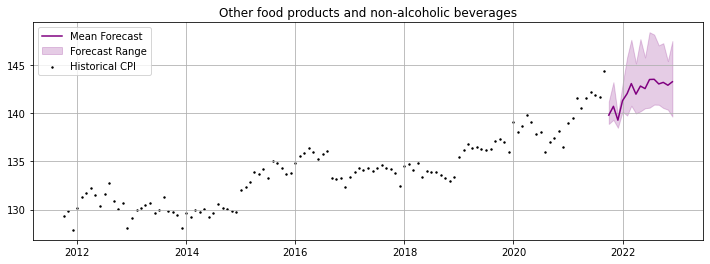

DEXCAUS_nlags_24
WILL5000IND_nlags_60
CPGRLE01CAM657N_nlags_60


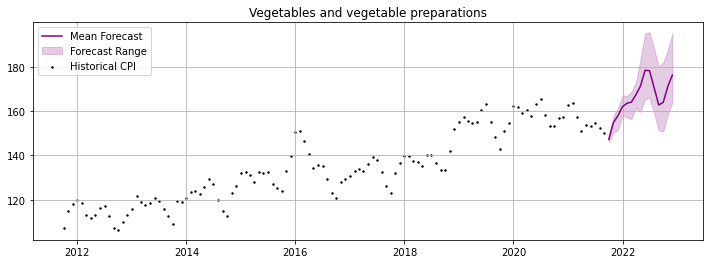

In [364]:
for category in food_categories:

    fig, ax = plt.subplots(figsize=(12,4))
    final_forecasts_df = get_final_forecast_ensemble(category, results)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]

    ax.plot(final_forecasts_df.mean(axis=1), color="purple", label="Mean Forecast")
    ax.fill_between(final_forecasts_df.mean(axis=1).index, final_forecasts_df.min(axis=1), final_forecasts_df.max(axis=1), color="purple", alpha=0.2, label='Forecast Range')
    ax.scatter(foodprice_df[category].index[-120:], foodprice_df[category].iloc[-120:], color='black', s=2, label='Historical CPI')

    plt.title(category)
    plt.legend(loc='upper left')
    plt.grid()
    # plt.savefig(f"./report_output/ensemble_forecast_{category}.svg", bbox_inches='tight')
    plt.show()


## Forecast as Predicted Percent Change

Below we compute the expected change in CPI for 2022, relative to mean CPIs in 2021 so far. 

In [373]:
food_forecast_stats = {}
food_forecast_change_stats = {}

for category in food_categories:

    forecast_stats = {}
    forecast_change_stats = {}

    final_forecasts_df = get_final_forecast_ensemble(category, results)
    final_forecasts_df = final_forecasts_df.loc[final_forecasts_df.index < "2023-01-01"]
    historical_cpi = foodprice_df[category]
    
    fc_min = final_forecasts_df.min(axis=1)
    fc_mean = final_forecasts_df.mean(axis=1)
    fc_max = final_forecasts_df.max(axis=1)

    forecast_stats['min'] = historical_cpi.append(fc_min)
    forecast_stats['mean'] = historical_cpi.append(fc_mean)
    forecast_stats['max'] = historical_cpi.append(fc_max)

    food_forecast_stats[category] = pd.DataFrame(forecast_stats)
    food_forecast_stats[category] = food_forecast_stats[category].loc[food_forecast_stats[category].index < "2023-01-01"]

    fc_stats = food_forecast_stats[category].iloc[-12:]
    historical_data = foodprice_df[category].iloc[-9:]

    print(fc_stats)

    forecast_change_stats['2021_mean'] = historical_data.mean()
    forecast_change_stats['2021_max'] = historical_data.max()
    forecast_change_stats['2022_fc_min'] = fc_stats.min().min() 
    forecast_change_stats['2022_fc_mean'] = fc_stats.mean().mean()
    forecast_change_stats['2022_fc_max'] = fc_stats.max().max()

    food_forecast_change_stats[category] = pd.Series(forecast_change_stats)


IRLTLT01CAM156N_nlags_36
nbeatsfredvars_202110
CUSR0000SAF112_nlags_24
             min  mean   max
2022-01-01 153.3 156.4 159.1
2022-02-01 154.2 156.3 159.2
2022-03-01 154.3 157.4 159.2
2022-04-01 156.2 158.8 161.0
2022-05-01 156.1 158.1 159.3
2022-06-01 155.3 158.9 161.7
2022-07-01 155.7 157.9 160.8
2022-08-01 155.5 158.6 160.4
2022-09-01 155.6 158.2 159.7
2022-10-01 156.5 160.6 164.8
2022-11-01 156.1 159.6 162.6
2022-12-01 156.9 160.9 166.2
CUSR0000SAF112_nlags_48
nbeats_202110
             min  mean   max
2022-01-01 147.5 148.9 150.3
2022-02-01 144.9 146.7 148.5
2022-03-01 147.7 148.0 148.3
2022-04-01 145.7 147.3 148.9
2022-05-01 147.6 148.3 149.0
2022-06-01 149.2 150.0 150.8
2022-07-01 149.5 150.4 151.3
2022-08-01 148.6 149.1 149.6
2022-09-01 149.1 150.6 152.1
2022-10-01 147.9 148.5 149.1
2022-11-01 144.3 146.6 149.0
2022-12-01 148.9 148.9 149.0
CUSR0000SAF113_nlags_48
nbeats_202110
QCAR368BIS_nlags_60
             min  mean   max
2022-01-01 147.2 149.2 152.7
2022-02-01 147.8 149.

In [366]:
pd.set_option('display.float_format', lambda x: '%.1f' % x)

results_df = pd.DataFrame(food_forecast_change_stats).T
results_df

,2021_mean,2021_max,2022_fc_min,2022_fc_mean,2022_fc_max
Bakery and cereal products (excluding baby food),157.1,158.5,153.3,158.4,166.2
Dairy products and eggs,145.6,148.3,144.3,148.6,152.1
"Fish, seafood and other marine products",145.7,147.6,147.2,151.2,157.3
Food purchased from restaurants,164.0,165.9,167.2,172.6,180.5
Food,156.6,158.5,152.3,158.7,163.8
"Fruit, fruit preparations and nuts",142.5,144.5,140.2,147.6,159.1
Meat,176.1,184.8,180.1,184.7,189.9
Other food products and non-alcoholic beverages,141.4,144.3,139.6,143.2,148.4
Vegetables and vegetable preparations,155.4,163.8,150.9,169.9,195.5


In [371]:
results_df[['2021_mean', '2022_fc_mean']]

,2021_mean,2022_fc_mean
Bakery and cereal products (excluding baby food),157.1,158.4
Dairy products and eggs,145.6,148.6
"Fish, seafood and other marine products",145.7,151.2
Food purchased from restaurants,164.0,172.6
Food,156.6,158.7
"Fruit, fruit preparations and nuts",142.5,147.6
Meat,176.1,184.7
Other food products and non-alcoholic beverages,141.4,143.2
Vegetables and vegetable preparations,155.4,169.9


In [374]:
## percent change formula from Jim
# P1 = P_0*CPI_1/100 and P2 = P_0*CPI_2/100

p1 = results_df['2021_mean']
p2 = results_df['2022_fc_mean']

(((p2-p1) / p1) * 100).to_frame()


,0
Bakery and cereal products (excluding baby food),0.8
Dairy products and eggs,2.1
"Fish, seafood and other marine products",3.8
Food purchased from restaurants,5.2
Food,1.4
"Fruit, fruit preparations and nuts",3.6
Meat,4.9
Other food products and non-alcoholic beverages,1.3
Vegetables and vegetable preparations,9.3


In [375]:
## percent change formula from Jim
# P1 = P_0*CPI_1/100 and P2 = P_0*CPI_2/100

p1 = results_df['2021_max']
p2 = results_df['2022_fc_max']

(((p2-p1) / p1) * 100).to_frame()


,0
Bakery and cereal products (excluding baby food),4.9
Dairy products and eggs,2.6
"Fish, seafood and other marine products",6.6
Food purchased from restaurants,8.8
Food,3.4
"Fruit, fruit preparations and nuts",10.1
Meat,2.7
Other food products and non-alcoholic beverages,2.8
Vegetables and vegetable preparations,19.4


In [24]:
## Actual percent change from 2020 to 2021 (Up to September, 2021)

p1 = foodprice_df.loc[foodprice_df.index < "2021-01-01"]
p1 = p1.loc[p1.index >= "2020-01-01"]
p1 = p1.mean(axis=0).rename("2020 Mean CPI")

p2 = foodprice_df.loc[foodprice_df.index < "2022-01-01"]
p2 = p2.loc[p2.index >= "2021-01-01"]
p2 = p2.mean(axis=0).rename("2021 Mean CPI")

result = (((p2-p1) / p1) * 100).rename("Percent Change")
pd.concat((p1, p2, result), axis=1)

,2020 Mean CPI,2021 Mean CPI,Percent Change
Bakery and cereal products (excluding baby food),157.517,157.144,-0.236
Dairy products and eggs,141.267,145.589,3.060
"Fish, seafood and other marine products",145.142,145.733,0.408
Food purchased from restaurants,159.925,163.967,2.527
Food,153.708,156.556,1.852
"Fruit, fruit preparations and nuts",139.142,142.522,2.430
Meat,171.242,176.111,2.844
Other food products and non-alcoholic beverages,137.958,141.356,2.462
Vegetables and vegetable preparations,159.025,155.444,-2.252


In [362]:
pct_change_from_mean_results = {}
pct_change_from_max_results = {}

for col in ['2022_fc_min', '2022_fc_mean', '2022_fc_max']:
    change = results_df[["2021_mean", col]].T.pct_change(1)
    pct_change_from_mean_results[col] = change.T[col]
    change = results_df[["2021_max", col]].T.pct_change(1)
    pct_change_from_max_results[col] = change.T[col]

In [367]:
pd.DataFrame(pct_change_from_mean_results)* 100

,2022_fc_min,2022_fc_mean,2022_fc_max
Bakery and cereal products (excluding baby food),166.2,256.4,369.6
Dairy products and eggs,319.4,476.2,651.9
"Fish, seafood and other marine products",163.4,349.8,536.2
Food purchased from restaurants,395.9,585.0,820.5
Food,347.0,477.0,578.7
"Fruit, fruit preparations and nuts",55.9,228.1,323.2
Meat,743.3,1085.1,1376.0
Other food products and non-alcoholic beverages,298.6,426.2,571.6
Vegetables and vegetable preparations,-347.4,41.1,438.3


In [329]:
pd.DataFrame(pct_change_from_max_results)

,2022_fc_min,2022_fc_mean,2022_fc_max
Bakery and cereal products (excluding baby food),0.3,1.2,2.3
Dairy products and eggs,0.5,2.1,3.8
"Fish, seafood and other marine products",-0.2,1.6,3.5
Food purchased from restaurants,2.0,3.9,6.3
Food,1.5,2.8,3.8
"Fruit, fruit preparations and nuts",-1.4,0.3,1.3
Meat,-1.3,2.2,5.1
Other food products and non-alcoholic beverages,0.0,1.3,2.8
Vegetables and vegetable preparations,-11.8,-7.9,-4.0


## Percent change of 2021 data compared to 2020

In [259]:
mean_2021 = foodprice_df.iloc[-9:].mean(axis=0)
mean_2020 = foodprice_df.iloc[-9-12:-9].mean(axis=0)
(pd.concat((mean_2020, mean_2021), axis=1).T).diff().T


,0,1
Bakery and cereal products (excluding baby food),NaN,-0.4
Dairy products and eggs,NaN,4.3
"Fish, seafood and other marine products",NaN,0.6
Food purchased from restaurants,NaN,4.0
Food,NaN,2.8
"Fruit, fruit preparations and nuts",NaN,3.4
Meat,NaN,4.9
Other food products and non-alcoholic beverages,NaN,3.4
Vegetables and vegetable preparations,NaN,-3.6
